# Run if on Google Colab

In [ ]:
%pip install git+https://github.com/deepmind/dm-haiku
%pip install jaxopt
%pip install optax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-1mjelmbo
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-1mjelmbo
  Resolved https://github.com/deepmind/dm-haiku to commit 94d136270265d7244d56005c91f2e75988b827d8
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.11.dev0-py3-none-any.whl size=370981 sha256=4219651caa2ea46c2c4d4fdcaa0a5fd6bef5c28c95a8d8c5a07e1ee9cc72c6aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-0eiolxic/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Set-up google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up Environment

In [ ]:

#Set seed
seed = 42

# Import packages
import optax
from typing import NamedTuple
import functools
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import haiku as hk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from itertools import product
import pickle
import jaxopt
from typing import Callable
from typing import Dict
from typing import NamedTuple
from flax import struct
import stochasticfisher as sf
import myjaxutil as myjax
from mynetworks import LinearLayer
import pandas as pd
from jax import config
import os
import seaborn as sns
import imageio
import statsmodels.api as sm


# config.update("jax_debug_nans", True)
jax.numpy.set_printoptions(precision=3, threshold = 3)

# Augmented Lagrangian Method

## Helper functions

In [ ]:
def get_lagrangian_function_exploit(obj, exploit):
    """
    Returns a function that computes the Lagrangian function of the given objective function and exploit function.

    Args:
    obj: A function that takes in two arguments, l_action and f_action, and returns a scalar value.
    exploit: A function that takes in two arguments, l_action and f_action, and returns a scalar value.

    Returns:
    A function that takes in three arguments, l_action, f_action, and langmult, and returns a scalar value.
    """

    @jax.jit
    def lagrangian(l_action, f_action, langmult, init_exploit_params):
        """
        Computes the Lagrangian function of the given objective function and exploit function.

        Args:
        l_action: A numpy array representing the action of the learner.
        f_action: A numpy array representing the action of the follower.
        langmult: A scalar value representing the Lagrange multiplier.

        Returns:
        A scalar value representing the Lagrangian function.
        """

        return jnp.squeeze(obj(l_action, f_action) + langmult * exploit(l_action, f_action, **init_exploit_params))

    return lagrangian


def get_penalty_function_exploit(obj, exploit):
    """
    Returns a function that computes the penalty function of the given objective function and exploit function.

    Args:
    obj: A function that takes in two arguments, l_action and f_action, and returns a scalar value.
    exploit: A function that takes in two arguments, l_action and f_action, and returns a scalar value.

    Returns:
    A function that takes in four arguments, l_action, f_action, langmult, and beta, and returns a scalar value.
    """

    @jax.jit
    def penalty_function(l_action, f_action, langmult, beta, init_exploit_params):
        """
        Computes the penalty function of the given objective function and exploit function.

        Args:
        l_action: A numpy array representing the action of the learner.
        f_action: A numpy array representing the action of the follower.
        langmult: A scalar value representing the Lagrange multiplier.
        beta: A scalar value representing the penalty parameter.

        Returns:
        A scalar value representing the penalty function.
        """
        f_exploit, exploit_params = exploit(l_action, f_action, **init_exploit_params)
        return jnp.squeeze(obj(l_action, f_action) + langmult * f_exploit + (beta/2)*jnp.power(f_exploit, 2)), exploit_params

    return penalty_function

## Main Routine

In [ ]:
def run_augmented_lagranian_exploit(problem, init_params, learn_rates, num_iters, beta_mult, beta, opt_name, init_exploit_params = {}, evaluate = lambda x,y: {"Penalty Function Value":[None], "Exploitability": [None]}, plot_price_prediction = lambda x,y: None):

    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    obj, exploit, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))
    penalty_func = get_penalty_function_exploit(obj, exploit)

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower), learn_rate_langmult = learn_rates
    num_iters_players, num_iters_langmult = num_iters

    # Unpack initial parameters
    l_action, f_action, langmult = init_params

    @jax.jit
    def player_step(l_action, f_action, langmult, beta, leader_opt_state, follower_opt_state, init_exploit_params):
        grads_leader, exploit_params = jax.grad(penalty_func, argnums = 0, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)
        grads_follower, exploit_params = jax.grad(penalty_func, argnums = 1, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state, new_follower_opt_state), exploit_params

    @jax.jit
    def langmult_step(l_action, f_action, langmult, beta, init_exploit_params):
        grads, exploit_params = jax.grad(penalty_func, argnums = 2, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)
        negated_grads = jax.tree_util.tree_map(lambda x: -x, grads)
        updates, new_state = langmult_update(negated_grads, langmult_opt_state, langmult)
        new_langmult = optax.apply_updates(langmult, updates)
        return (new_langmult, new_state), exploit_params

    # Initialize Lagrangian Optimizer
    langmult_update, langmult_opt_state = myjax.init_optimiser(learn_rate_langmult, langmult, opt_name)

    # Initialize iteration counters
    iter_langmult = 0
    iter_player = 0

    # Initialize data dictionary to store the history of training
    data_hist = evaluate(l_action, f_action)

    figure_hist = []

    # Print initial values
    print("Lagrange multiplier: ", langmult)

    while iter_langmult <= num_iters_langmult:
        l_payoff = obj(l_action, f_action)
        exploit_val, init_exploit_params = exploit(l_action, f_action, **init_exploit_params)
        penalty_func_val, init_exploit_params = penalty_func(l_action, f_action, langmult, beta, init_exploit_params)

        print(f"\033[1m============================================================ Lagrangian Iteration -- {iter_langmult} ============================================================\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mLeader Payoff: {l_payoff:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mExploit: {exploit_val:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value: {penalty_func_val:.4f}\033[0m")


        # Reinitialize player optimizers
        leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
        follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)

        iter_player = 0
        action_norm_change = float("inf")
        while iter_player <= num_iters_players:

            print(f"\t\t**************************** Lagrangian Iteration: {iter_langmult} // Player Iteration: {iter_player}  ****************************")
            if iter_player % 1 == 0:
                fig = plot_price_prediction(l_action, f_action)
                figure_hist.append(fig)
            iter_regret = 0
            br_norm_change = float("inf")

            # Player actions update step
            (l_action, f_action), (leader_opt_state, follower_opt_state), init_exploit_params = player_step(l_action, f_action, langmult, beta, leader_opt_state, follower_opt_state, init_exploit_params)

            if iter_player % 10 == 0:
                print(f"Market Predicted: {l_action}")

            iter_player += 1

            if iter_player % 1 == 0:
                # print("Leader action:", l_action, "\nFollower action", f_action)
                # l_payoff = obj(l_action, f_action)
                exploit_val, init_exploit_params = exploit(l_action, f_action, **init_exploit_params)
                penalty_func_val, init_exploit_params = penalty_func(l_action, f_action, langmult, beta, init_exploit_params)


                # print(f"\t\t\t\t\t\t\t\033[1mLeader Payoff: {l_payoff:.4f}\033[0m")
                print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")
                print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value: {penalty_func_val:.4f}\033[0m")

                print("\t\t\t\t\t\t\t----------------------------------")
                results = evaluate(l_action, f_action)
                results["Penalty Function Value"][-1] = penalty_func_val
                results["Exploitability"][-1] = exploit_val

                data_hist = jax.tree_util.tree_map(lambda x, y: x + y, data_hist, results)


                for key, value in results.items():
                    print(f"\t\t\t\t\t\t\t\033[1m{key}\033[0m: {value[-1]:.4f}")

        (langmult, langmult_opt_state), init_exploit_params = langmult_step(l_action, f_action, langmult, beta, init_exploit_params)




        print(f"Lagrange: Multipliers {langmult}")
        print(f"Beta: {beta}")
        beta *= beta_mult
        iter_langmult += 1

    return (l_action, f_action, langmult), (data_hist, figure_hist)

# Static Fisher Market Experiments

In [ ]:
# Fitting a Fisher market
def get_fisher_exploit(allocations, prices, market, util_type = "linear"):
    budgets = jnp.clip(market["budgets"], a_min=1e-4)
    valuations = jnp.clip(market["valuations"], a_min=1e-4)
    supplies = jnp.clip(market["supplies"], a_min=1e-4)
    rho = market["rho"]

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return dual - primal


## Solve Market

In [ ]:
market = {"valuations": jnp.array([[1.0, 2.0], [3.0, 1.0], [1.0, 1.0]]),
          "budgets": jnp.array([1/3, 1/3, 1/3]),
          "supplies": jnp.array([1.0, 1.0]),
          "rho": jnp.array([0.5, 0.5, 0.5])}
util_type = "linear"

p0 = jnp.array([1.0, 1.0])
X0 = jnp.array([[0.1, 0.1], [0.1, 0.1], [0.1, 0.1]])
proj = lambda x: (jnp.clip(x[0], a_min=1e-8), jnp.clip(x[1], a_min=1e-8))

obj = lambda x: get_fisher_exploit(*x, market, util_type)
print("======================== Solving market ========================")

X, p = myjax.minimize(obj, (X0, p0), proj = proj, num_iters=10000, lr=1e-3, name = "adam")

print(f"Equilibrium: {(X, p)}, Objective {obj((X, p))}")

======================== Solving market ========================
Iteration 0, loss 1.04187
Iteration 100, loss 0.60599
Iteration 200, loss 0.40970
Iteration 300, loss 0.28305
Iteration 400, loss 0.19502
Iteration 500, loss 0.13286
Iteration 600, loss 0.08661
Iteration 700, loss 0.05621
Iteration 800, loss 0.03882
Iteration 900, loss 0.02612
Iteration 1000, loss 0.01871
Iteration 1100, loss 0.01374
Iteration 1200, loss 0.01008
Iteration 1300, loss 0.00764
Iteration 1400, loss 0.00581
Iteration 1500, loss 0.00421
Iteration 1600, loss 0.00314
Iteration 1700, loss 0.00236
Iteration 1800, loss 0.00183
Iteration 1900, loss 0.00197
Iteration 2000, loss 0.00115
Iteration 2100, loss 0.00107
Iteration 2200, loss 0.00083
Iteration 2300, loss 0.00051
Iteration 2400, loss 0.00054
Iteration 2500, loss 0.00029
Iteration 2600, loss 0.00027
Iteration 2700, loss 0.00028
Iteration 2800, loss 0.00036
Iteration 2900, loss 0.00026
Iteration 3000, loss 0.00027
Iteration 3100, loss 0.00018
Iteration 3200, los

## Estimate Market

In [ ]:
def estimate_market_params(X, p, learn_rates, num_iters, beta_mult, beta, util_type = "linear", opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"valuations": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0, maxval = 10),
                "budgets": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers,), minval = 0.0, maxval = 10.0),
                "supplies": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods, ), minval = 0.0, maxval = 10.0),
                "rho": jnp.array([0.5, 0.5, 0.5])}

    init_X = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
    init_p = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods,), minval = 0.0, maxval = 10.0)
    init_langmult = jax.random.uniform(jax.random.PRNGKey(seed), shape = (1,), minval = 0.0, maxval = 1.0)
    init_params = (init_market_params, (init_X, init_p), init_langmult)


    def obj(l_action, f_action):
        f_X, f_p = f_action
        return (1/2)*(jnp.linalg.norm(X - f_X) + jnp.linalg.norm(p - f_p))**2

    def exploit(l_action, f_action):
        return get_fisher_exploit(*f_action, l_action, util_type), {}

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1e-4, a_max = 3.0), l_action)
        l_action_proj["budgets"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1/3, a_max=1/3), l_action_proj["budgets"])
        l_action_proj["supplies"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=1.0), l_action_proj["supplies"])

        return l_action_proj

    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-4), x[1].clip(1e-4))

    problem = (obj, exploit, l_project, f_project)

    return run_augmented_lagranian_exploit(problem, init_params, learn_rates, num_iters, beta_mult, beta, opt_name)

In [ ]:
# Correct market parameters
# market = {"valuations": jnp.array([[1.0, 2.0],
#                                    [3.0, 1.0],
#                                    [1.0, 1.0]]),
        #   "budgets": jnp.array([1/3, 1/3, 1/3]),
        #   "supplies": jnp.array([1.0, 1.0]),
        #   "rho": jnp.array([0.5, 0.5, 0.5])}

# Equilibrium
X = jnp.array([[0.0, 2/3], [2/3, 0.0], [1/3, 1/3]])
p = jnp.array([1/2, 1/2])


util_type = "cobb-douglas"

learn_rate_langmult = 1e-2
learn_rate_players = (1e-3, 5e-4)
beta_mult = 1.1
beta = 1.0
num_iters_players = 10000
num_iters_langmult = 100
opt_name = "adam"


num_iters = (num_iters_players, num_iters_langmult)
learn_rates = (learn_rate_players, learn_rate_langmult)

(l_action, f_action, langmult), data = estimate_market_params(X, p, learn_rates, num_iters, beta_mult, beta, util_type, opt_name)


# init_market_params = {"valuations": jax.random.uniform(jax.random.PRNGKey(seed), shape = (3,2), minval = 0, maxval = 10),
#                 "budgets": jax.random.uniform(jax.random.PRNGKey(seed), shape = (3,), minval = 0, maxval = 10),
#                 "supplies": jax.random.uniform(jax.random.PRNGKey(seed), shape = (2, ), minval = 0, maxval = 10),
#                 "rho": jnp.array([0.5, 0.5, 0.5])}

# init_market_params = {"valuations": jnp.array([[2.0, 2.0], [3.0, 3.0], [2.0, 3.0]]),
#                 "budgets": jnp.array([1/4, 1/2, 1/4]),
#                 "supplies": jnp.array([1.0, 1.0]),
#                 "rho": jnp.array([0.5, 0.5, 0.5])}

Lagrange multiplier:  [0.427]


TypeError: ignored

In [ ]:
def plot_loss_dict(losses):
    num_losses = len(losses)
    num_rows = (num_losses - 1) // 3 + 1
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    for i, (name, loss) in enumerate(losses.items()):
        row = i // 3
        col = i % 3
        if num_rows == 1:
            axs[col].plot(loss)
            axs[col].set_title(name)
            continue
        axs[row, col].plot(loss)
        axs[row, col].set_title(name)
    plt.show()

plot_loss_dict(data)


# Gradient Descent Ascent

In [ ]:
def run_GDA(problem, init_params, goal_params, learn_rates, num_iters, opt_name="adam"):


    exploit_hist = []
    dist_hist = []
    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    exploit, cumul_regret, neg_cumul_regret, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower) = learn_rates
    num_iters_players = num_iters

    # Unpack initial parameters
    l_action, f_action = init_params
    l_goal, f_goal = goal_params

    # @jax.jit
    def player_step(l_action, f_action, leader_opt_state, follower_opt_state):
        value_leader, grads_leader = jax.value_and_grad(cumul_regret, argnums = 0)(l_action, f_action)
        value_follower, grads_follower = jax.value_and_grad(neg_cumul_regret, argnums = 1)(l_action, f_action)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state, new_follower_opt_state)


    # Initialize iteration counters
    iter_player = 0


    # Reinitialize player optimizers
    leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
    follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)
    while iter_player <= num_iters_players:
        # Player actions update step
        (l_action, f_action), (leader_opt_state, follower_opt_state) = player_step(l_action, f_action, leader_opt_state, follower_opt_state)
        if iter_player % 10 == 0:
            print(f"\t\t**************************** Player Iteration: {iter_player}  ****************************")
            print(f"Leader Predicted: {l_action}")
            print(f"Follower Predicted: {f_action}")



            exploit_val = exploit(l_action, f_action)
            exploit_hist.append(exploit_val)
            print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")

            flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
            dist_dict = {}
            for key_path, value in flattened:
                # print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
                key = jax.tree_util.keystr(key_path)[2:-2]
                dist = np.absolute(value-l_goal[key])
                dist_dict[key] = dist
                print(f"\t\t\t\t\t\t\t\033[1mDistance to true {key}: {dist}\033[0m")
            dist_hist.append(dist_dict)
            print("\t\t\t\t\t\t\t----------------------------------")

        iter_player += 1
    return (l_action, f_action), exploit_hist, dist_hist

# Max-Oracle GD

In [ ]:
def run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name="adam"):


    exploit_hist = []
    dist_hist = []
    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    exploit, cumul_regret, best_response, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower) = learn_rates
    num_iters_players = num_iters

    # Unpack initial parameters
    l_action, f_action = init_params
    l_goal, f_goal = goal_params

    # @jax.jit
    def player_step(l_action, f_action, leader_opt_state, follower_opt_state):
        value_leader, grads_leader = jax.value_and_grad(cumul_regret, argnums = 0)(l_action, f_action)
        # value_follower, grads_follower = jax.value_and_grad(neg_cumul_regret, argnums = 1)(l_action, f_action)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        # f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        # new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = best_response(new_l_action)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state)


    # Initialize iteration counters
    iter_player = 0


    # Reinitialize player optimizers
    leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
    follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)
    while iter_player <= num_iters_players:
        # Player actions update step
        (l_action, f_action), (leader_opt_state) = player_step(l_action, f_action, leader_opt_state, follower_opt_state)
        if iter_player % 10 == 0:
            print(f"\t\t**************************** Player Iteration: {iter_player}  ****************************")
            print(f"Leader Predicted: {l_action}")
            print(f"Follower Predicted: {f_action}")



            exploit_val = exploit(l_action, f_action)
            exploit_hist.append(exploit_val)
            print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")

            flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
            dist_dict = {}
            for key_path, value in flattened:
                # print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
                key = jax.tree_util.keystr(key_path)[2:-2]
                dist = np.absolute(value-l_goal[key])
                dist_dict[key] = dist
                print(f"\t\t\t\t\t\t\t\033[1mDistance to true {key}: {dist}\033[0m")
            dist_hist.append(dist_dict)
            print("\t\t\t\t\t\t\t----------------------------------")

        iter_player += 1
    return (l_action, f_action), exploit_hist, dist_hist

# Exploit GD

In [ ]:
from decorator import dispatch_on
def run_exploit_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name="adam", epsilon=1e-2):


    exploit_hist = []
    dist_hist = []
    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    exploit, best_response, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower) = learn_rates
    num_iters_players = num_iters

    # Unpack initial parameters
    l_action, f_action = init_params
    l_goal, f_goal = goal_params

    # @jax.jit
    def player_step(l_action, f_action, leader_opt_state):
        value_leader, grads_leader = jax.value_and_grad(exploit, argnums = 0)(l_action)
        # value_follower, grads_follower = jax.value_and_grad(neg_cumul_regret, argnums = 1)(l_action, f_action)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        # f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        # # new_f_action = optax.apply_updates(f_action, f_updates)
        # new_f_action = best_response(new_l_action)
        # new_f_action = f_project(new_f_action)

        return (new_l_action), (new_leader_opt_state)


    # Initialize iteration counters
    iter_player = 0


    # Reinitialize player optimizers
    leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
    # follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)
    while iter_player <= num_iters_players:
        # Player actions update step
        (l_action), (leader_opt_state) = player_step(l_action, f_action, leader_opt_state)

        if iter_player % 10 == 0:
            exploit_val = exploit(l_action)
            exploit_hist.append(exploit_val)
            if iter_player % 1000 == 0:
                print(f"\t\t**************************** Player Iteration: {iter_player}  ****************************")
                print(f"Leader Predicted: {l_action}")
                f_action = best_response(l_action)
                print(f"Follower Predicted: {f_action}")
                print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")
            flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
            dist_dict = {}
            error = 0
            for key_path, value in flattened:
                # print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
                key = jax.tree_util.keystr(key_path)[2:-2]
                dist = np.linalg.norm((value-l_goal[key])/l_goal[key])
                dist_dict[key] = dist
                error += dist
                if iter_player % 1000 == 0:
                  print(f"\t\t\t\t\t\t\t\033[1mDistance to true {key}: {dist}\033[0m")
            dist_hist.append(dist_dict)
            if error <= epsilon:
                print("Parameters recovered, break early.")
                print(f"Leader Predicted: {l_action}")
                print(f"Follower Predicted: {f_action}")
                print(f"Exploitability: {exploit_val}")
                print(f"Error: {error}")
                break

        iter_player += 1
    return (l_action), exploit_hist, dist_hist

# Traveler's Dilemma

In [ ]:
def get_travelersDilemma_exploit(x, y, reward, num_actions):
    # Generate Payoff matrices
    X_matrix = jnp.zeros((num_actions, num_actions))
    Y_matrix = jnp.zeros((num_actions, num_actions))
    for x in range(num_actions):
      for y in range(num_actions):
        actions = jnp.array([x+reward, y+reward])
        X_matrix = X_matrix.at[x,y].set(jnp.min(actions) + reward * (y-x) / jnp.absolute(x-y).clip(min=0.5))
        Y_matrix = Y_matrix.at[x,y].set(jnp.min(actions) + reward * (x-y) / jnp.absolute(x-y).clip(min=0.5))

    # exploit for x
    x_exploit = jnp.max(X_matrix @ y) - x.T @ X_matrix @ y
    # exploit for y
    y_exploit = jnp.max(x.T @ Y_matrix)- x.T @ Y_matrix @ y

    return x_exploit + y_exploit

In [ ]:
def estimate_travelersDilemma_params(x, y, learn_rates, num_iters, beta_mult, beta, num_actions, opt_name = "adam"):

    # init_market_params = {"valuations": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0, maxval = 10),
    #             "budgets": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers,), minval = 0.0, maxval = 10.0),
    #             "supplies": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods, ), minval = 0.0, maxval = 10.0),
    #             "rho": jnp.array([0.5, 0.5, 0.5])}
    init_reward = jax.random.uniform(jax.random.PRNGKey(seed), shape=(), minval=1.0, maxval=100.0)

    # init_X = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
    # init_p = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods,), minval = 0.0, maxval = 10.0)
    init_x = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_actions,), minval = 0.0, maxval = 1.0)
    init_y = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_actions,), minval = 0.0, maxval = 1.0)
    init_langmult = jax.random.uniform(jax.random.PRNGKey(seed), shape = (1,), minval = 0.0, maxval = 1.0)
    init_params = (init_reward, (init_x, init_y), init_langmult)

    def obj(l_action, f_action):
        f_x, f_y = f_action
        return (1/2)*(jnp.linalg.norm(x - f_x) + jnp.linalg.norm(y - f_y))**2

    def exploit(l_action, f_action):
        return get_travelersDilemma_exploit(*f_action, l_action, num_actions), {}

    l_project = lambda r: jnp.clip(r, a_min=1, a_max=num_actions)
    f_project = lambda X: (jax.nn.softmax(X[0]), jax.nn.softmax(X[1])) #project to unit simplex

    problem = (obj, exploit, l_project, f_project)

    return run_augmented_lagranian_exploit(problem, init_params, learn_rates, num_iters, beta_mult, beta, opt_name)

In [ ]:
num_actions = 300

# Equilibrium
x = jnp.zeros((num_actions))
y = jnp.zeros((num_actions))
x = x.at[0].set(1)
y = y.at[0].set(1)


# util_type = "cobb-douglas"

learn_rate_langmult = 1e-2
learn_rate_players = (1e-3, 5e-4)
beta_mult = 1.1
beta = 1.0
num_iters_players = 1000
num_iters_langmult = 100
opt_name = "adam"


num_iters = (num_iters_players, num_iters_langmult)
learn_rates = (learn_rate_players, learn_rate_langmult)

(l_action, f_action, langmult), data = estimate_travelersDilemma_params(x, y, learn_rates, num_iters, beta_mult, beta, num_actions, opt_name)

# Bertrand Compitition

## Bertrand Competition (Learn Demand Func + Marginal Cost)





In [ ]:
slope = -3
intercept = 50
c=3
p0=1.0

p1_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1.0), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
print(p1_opt)


condition_constant = jnp.select(condlist=[1<1, 1==1, 1>1], choicelist=[0, 1/2, 1], default=0)
print(condition_constant)

9.833332
0.5


In [ ]:
@jax.jit
def get_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    # u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c) * (p1_star<=p2_star) * ((p1_star<p2_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p1_star<p2_star, p1_star==p2_star, p1_star>p2_star], choicelist=[1, 1/2, 0], default=1)
    u1_star = jax.nn.relu(slope*p1_star+intercept).clip(0.01)*(p1_star-c)*condition_constant_star
    # reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*(p1<=p2_star)*((p1<p2_star)/2+ 1/2) - u1_star

    # deviation from eqm. util
    condition_constant = jnp.select(condlist=[p1<p2_star, p1==p2_star, p1>p2_star], choicelist=[1, 1/2, 0], default=1)
    reg1 = (p1-c)*jax.nn.relu(slope*p1+intercept).clip(0.01)*condition_constant - u1_star


    # u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c) * (p2_star<=p1_star) * ((p2_star<p1_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p2_star<p1_star, p2_star==p1_star, p2_star>p1_star], choicelist=[1, 1/2, 0], default=1)
    u2_star = jax.nn.relu(slope*p2_star+intercept).clip(0.01)*(p2_star-c)*condition_constant_star

    # best-response util
    # reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*(p2<=p1_star)*((p2<p1_star)/2+ 1/2) - u2_star
    condition_constant = jnp.select(condlist=[p2<p1_star, p2==p1_star, p2>p1_star], choicelist=[1, 1/2, 0], default=1)
    reg2 = jax.nn.relu(slope*p2+intercept).clip(0.01)*(p2-c)*condition_constant - u2_star

    return reg1+reg2
@jax.jit
def get_neg_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star):
    cumul_regret = get_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star)
    return -1.0* cumul_regret

def get_Bertrand_best_response(market, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    p_init = 2.0
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2_star >= p1_opt:
        p1 = p1_opt
    elif c < p2_star and p2_star <p1_opt:
        p1 = p2_star - epsilon
    elif p2_star <= c:
        p1 = c

    p_init = 2.0
    p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1_star >= p2_opt:
        p2 = p2_opt
    elif c < p1_star and p1_star <p2_opt:
        p2 = p1_star - epsilon
    elif p1_star <= c:
        p2 = c

    return (p1, p2)

# @jax.jit
def get_Bertrand_exploit(p1, p2, market, epsilon):
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    p0 = 2.0
    u1 = jax.nn.relu(slope*p1+intercept)*(p1-c) * (p1<=p2) * ((p1<p2)/2+ 1/2)
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2 >= p1_opt:
        print("-----------------------------------------CASE 1-------------------------------------------")
        exploit1 = jax.nn.relu(slope*p1_opt+intercept)*(p1_opt-c) - u1
    elif c < p2 and p2 <p1_opt:
        print("-----------------------------------------CASE 2-------------------------------------------")
        exploit1 = jax.nn.relu(slope*(p2-epsilon)+intercept)*((p2-epsilon)-c) - u1
    elif p2 == c:
        print("-----------------------------------------CASE 3-------------------------------------------")
        exploit1 = 0 - u1
    else:
        print("-----------------------------------------CASE 4-------------------------------------------")
        exploit1 = 0 - u1

    u2 = jax.nn.relu(slope*p2+intercept)*(p2-c) * (p2<=p1) * ((p2<p1)/2+ 1/2)
    p2_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=c), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1 >= p2_opt:
        exploit2 = jax.nn.relu(slope*p2_opt+intercept)*(p2_opt-c) - u2
    elif c < p1 and p1 <p2_opt:
        exploit2 = jax.nn.relu(slope*(p1-epsilon)+intercept)*((p1-epsilon)-c) - u2
    elif p1==c:
        exploit2 = 0 - u2
    else:
        exploit2 = 0 - u2

    return exploit1+exploit2




### Experiment(GDA)

In [ ]:
def estimate_all_Bertrand_params(p1_star, p2_star, goal_params, learn_rates, num_iters, epsilon, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "demand_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -10, maxval = -1e-2),
                "demand_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 100.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def neg_cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_neg_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "demand_slope": -3,
          "demand_intercept": 100}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20


epsilon = 0.01

learn_rate_players = (1e-2, 5e-3)
num_iters = 4000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Bertrand_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, epsilon, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'demand_intercept': Array(48.405, dtype=float32), 'demand_slope': Array(-5.737, dtype=float32), 'marginal_cost': Array(5.424, dtype=float32)}
Follower Predicted: (Array(5.419, dtype=float32), Array(5.419, dtype=float32))
-----------------------------------------CASE 4-------------------------------------------
							Exploitability: 0.0866
							Distance to true demand_intercept: 51.594520568847656
							Distance to true demand_slope: 2.7369918823242188
							Distance to true marginal_cost: 14.576179504394531
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'demand_intercept': Array(48.497, dtype=float32), 'demand_slope': Array(-5.645, dtype=float32), 'marginal_cost': Array(5.524, dtype=float32)}
Follower Predicted: (Array(5.469, dtype=float32), Array(5.469, dtype=float32))
------------------

Text(0.5, 1.0, 'Demand Intercept Diff')

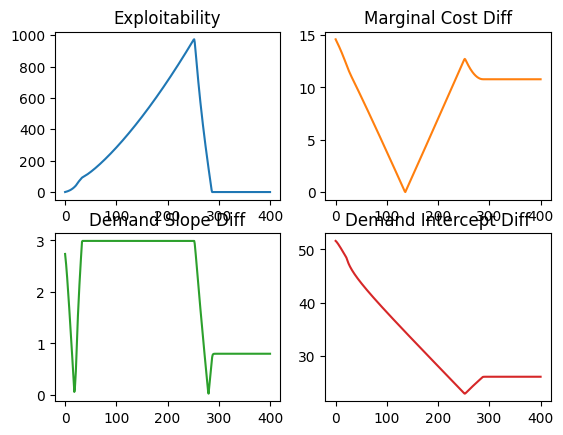

In [ ]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["demand_slope"])
    intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Demand Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Demand Intercept Diff')




### Experiment(Max Oracle GD)

In [ ]:
def estimate_all_Bertrand_params_GD(p1_star, p2_star, goal_params, learn_rates, num_iters, epsilon, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "demand_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -1.0, maxval = -1e-2),
                "demand_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 200.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def best_response(l_action):
        return get_Bertrand_best_response(l_action, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, best_response, l_project, f_project)

    return run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "demand_slope": -3,
          "demand_intercept": 100}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20


epsilon = 0.01

learn_rate_players = (6e-2, 5e-3)
num_iters = 1000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Bertrand_params_GD(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, epsilon, opt_name)

		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'demand_intercept': Array(91.138, dtype=float32), 'demand_slope': Array(-0.518, dtype=float32), 'marginal_cost': Array(5.474, dtype=float32)}
Follower Predicted: (Array(19.99, dtype=float32, weak_type=True), Array(19.99, dtype=float32, weak_type=True))
-----------------------------------------CASE 2-------------------------------------------
							Exploitability: 1171.3341
							Distance to true demand_intercept: 8.861770629882812
							Distance to true demand_slope: 2.482459783554077
							Distance to true marginal_cost: 14.526180267333984
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'demand_intercept': Array(90.737, dtype=float32), 'demand_slope': Array(-0.918, dtype=float32), 'marginal_cost': Array(6.066, dtype=float32)}
Follower Predicted: (Array(19.99, dtype=float32, weak_type=True)

Text(0.5, 1.0, 'Demand Intercept Diff')

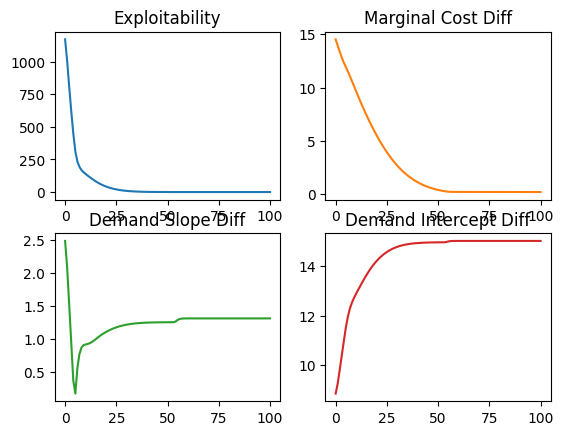

In [ ]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["demand_slope"])
    intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Demand Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Demand Intercept Diff')




## Bertrand Competition (Learn Marginal Cost Only)

In [ ]:
@jax.jit
def get_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]

    # u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c) * (p1_star<=p2_star) * ((p1_star<p2_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p1_star<p2_star, p1_star==p2_star, p1_star>p2_star], choicelist=[1, 1/2, 0], default=1)
    u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c)*condition_constant_star
    # reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*(p1<=p2_star)*((p1<p2_star)/2+ 1/2) - u1_star
    condition_constant = jnp.select(condlist=[p1<p2_star, p1==p2_star, p1>p2_star], choicelist=[1, 1/2, 1e-2], default=1)
    reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*condition_constant - u1_star


    # u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c) * (p2_star<=p1_star) * ((p2_star<p1_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p2_star<p1_star, p2_star==p1_star, p2_star>p1_star], choicelist=[1, 1/2, 0], default=1)
    u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c)*condition_constant_star
    # reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*(p2<=p1_star)*((p2<p1_star)/2+ 1/2) - u2_star
    condition_constant = jnp.select(condlist=[p2<p1_star, p2==p1_star, p2>p1_star], choicelist=[1, 1/2, 0], default=1)
    reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*condition_constant - u2_star

    return reg1+reg2
@jax.jit
def get_neg_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    cumul_regret = get_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star)
    return -cumul_regret

def get_Bertrand_best_response(market, slope, intercept, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]

    p_init = 2.0
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2_star >= p1_opt:
        p1 = p1_opt
    elif c < p2_star and p2_star <p1_opt:
        p1 = p2_star - epsilon
    elif p2_star <= c:
        p1 = c

    p_init = 2.0
    p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1_star >= p2_opt:
        p2 = p2_opt
    elif c < p1_star and p1_star <p2_opt:
        p2 = p1_star - epsilon
    elif p1_star <= c:
        p2 = c

    return (p1, p2)



# @jax.jit
def get_Bertrand_exploit(p1, p2, market, slope, intercept, epsilon):
    c = market["marginal_cost"]

    p0 = 2.0
    u1 = jax.nn.relu(slope*p1+intercept)*(p1-c) * (p1<=p2) * ((p1<p2)/2+ 1/2)
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2 >= p1_opt:
        print("-----------------------------------------CASE 1-------------------------------------------")
        exploit1 = jax.nn.relu(slope*p1_opt+intercept)*(p1_opt-c) - u1
    elif c < p2 and p2 <p1_opt:
        print("-----------------------------------------CASE 2-------------------------------------------")
        exploit1 = jax.nn.relu(slope*(p2-epsilon)+intercept)*((p2-epsilon)-c) - u1
    elif p2 == c:
        print("-----------------------------------------CASE 3-------------------------------------------")
        exploit1 = 0 - u1
    else:
        print("-----------------------------------------CASE 4-------------------------------------------")
        exploit1 = 0 - u1

    u2 = jax.nn.relu(slope*p2+intercept)*(p2-c) * (p2<=p1) * ((p2<p1)/2+ 1/2)
    p2_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=c), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1 >= p2_opt:
        exploit2 = jax.nn.relu(slope*p2_opt+intercept)*(p2_opt-c) - u2
    elif c < p1 and p1 <p2_opt:
        exploit2 = jax.nn.relu(slope*(p1-epsilon)+intercept)*((p1-epsilon)-c) - u2
    elif p1==c:
        exploit2 = 0 - u2
    else:
        exploit2 = 0 - u2

    return exploit1+exploit2




### Experiment(GDA)

In [ ]:
def estimate_Bertrand_params(p1_star, p2_star, goal_params, learn_rates, num_iters, slope, intercept, epsilon, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def neg_cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_neg_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, slope, intercept, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=100.0), l_action_proj["marginal_cost"])
        # l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        # l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
    #     key_path, c_value = flattened[0]
    #     f_action_proj = lambda x: (jnp.clip(x[0], a_min=c_value), jnp.clip(x[1], a_min=c_value))
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20

slope = -3
intercept = 100
epsilon = 0.01

learn_rate_players = (5e-2, 3e-2)
num_iters = 6000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Bertrand_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, epsilon, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.464, dtype=float32)}
Follower Predicted: (Array(5.444, dtype=float32), Array(5.444, dtype=float32))
-----------------------------------------CASE 4-------------------------------------------
							Exploitability: 1.6734
							Distance to true marginal_cost: 14.53618049621582
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'marginal_cost': Array(5.964, dtype=float32)}
Follower Predicted: (Array(5.744, dtype=float32), Array(5.744, dtype=float32))
-----------------------------------------CASE 4-------------------------------------------
							Exploitability: 18.1877
							Distance to true marginal_cost: 14.03648567199707
							----------------------------------
		**************************** Player Iteration: 20  ****************************
Leader Predicted: {'margin

Text(0.5, 1.0, 'Marginal Cost Diff')

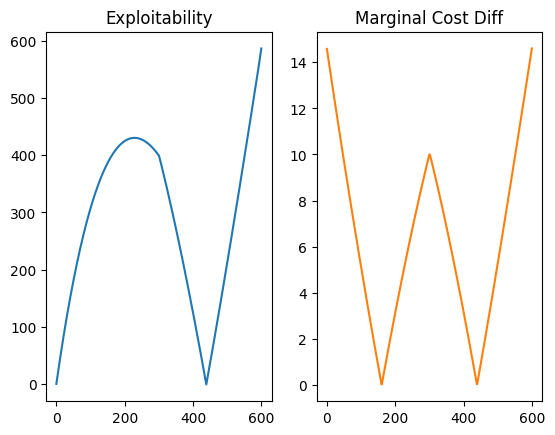

In [ ]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

### Experiment(Max Oracle GD)

In [ ]:
def estimate_Bertrand_params_GD(p1_star, p2_star, goal_params, learn_rates, num_iters, slope, intercept, epsilon, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def best_response(l_action):
        return get_Bertrand_best_response(l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, slope, intercept, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=100.0), l_action_proj["marginal_cost"])
        # l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        # l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
    #     key_path, c_value = flattened[0]
    #     f_action_proj = lambda x: (jnp.clip(x[0], a_min=c_value), jnp.clip(x[1], a_min=c_value))
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, best_response, l_project, f_project)

    return run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20

slope = -3
intercept = 100
epsilon = 0.01

learn_rate_players = (5e-2, 3e-2)
num_iters = 500
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Bertrand_params_GD(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, epsilon, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.464, dtype=float32)}
Follower Predicted: (Array(19.399, dtype=float32), Array(19.399, dtype=float32))
-----------------------------------------CASE 1-------------------------------------------
							Exploitability: 582.5321
							Distance to true marginal_cost: 14.53618049621582
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'marginal_cost': Array(5.882, dtype=float32)}
Follower Predicted: (Array(19.608, dtype=float32), Array(19.608, dtype=float32))
-----------------------------------------CASE 1-------------------------------------------
							Exploitability: 565.1821
							Distance to true marginal_cost: 14.11801528930664
							----------------------------------
		**************************** Player Iteration: 20  ****************************
Leader Predicted: {

Text(0.5, 1.0, 'Marginal Cost Diff')

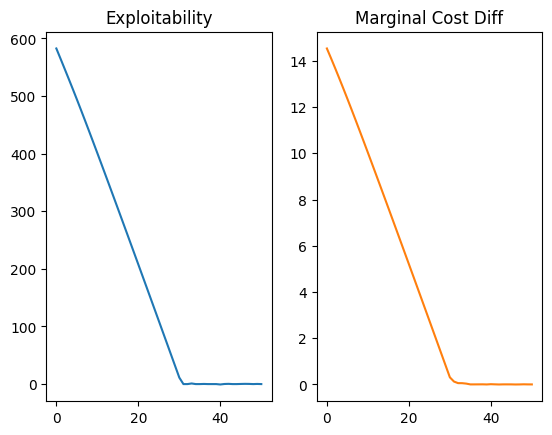

In [ ]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

# Cournot Competition

## Cournot Competition(Learn Price Func + Marginal Cost)

In [ ]:
from statsmodels.graphics.gofplots import qqline
@jax.jit
def get_Cournot_cumul_regret(q1, q2, market, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    # deviation from q1_star
    reg1 = (price_func(q1+q2_star)-c)*q1 - (price_func(q1_star+q2_star)-c)*q1_star
    # deviation from q2_star
    reg2 = (price_func(q1_star+q2)-c)*q2 - (price_func(q1_star+q2_star)-c)*q2_star

    return reg1+reg2
@jax.jit
def get_neg_Cournot_cumul_regret(q1, q2, market, q_star):
    cumul_regret = get_Cournot_cumul_regret(q1, q2, market, q_star)
    return -1.0 * cumul_regret

def get_Bertrand_best_response(market, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    q1 = (intercept-c)/(-2*slope) - q2_star/2
    q2 = (intercept-c)/(-2*slope) - q1_star/2


    return (q1, q2)


def get_Cournot_exploit(q1, q2, market):
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    q1_opt = (intercept-c)/(-2*slope) - q2/2
    exploit1 = (price_func(q1_opt+q2)-c)*q1_opt - (price_func(q1+q2)-c)*q1

    q2_opt = (intercept-c)/(-2*slope) - q1/2
    exploit2 = (price_func(q1+q2_opt)-c)*q2_opt - (price_func(q1+q2)-c)*q2

    return exploit1+exploit2

### Experiment(GDA)

In [ ]:
def estimate_all_Cournot_params(q1_star, q2_star, goal_params, learn_rates, num_iters, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "price_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -10, maxval = -1e-2),
                "price_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 100.0),
                }

    init_q1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_q2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_q1, init_q2))


    def cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_cumul_regret(*f_action, l_action, (q1_star, q2_star))

    def neg_cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_neg_Cournot_cumul_regret(*f_action, l_action, (q1_star, q2_star))

    def exploit(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_exploit(*f_action, l_action)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["price_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-100.0, a_max=-1e-2), l_action_proj["price_slope"])
        l_action_proj["price_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=1000.0), l_action_proj["price_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "price_slope": -3,
          "price_intercept": 100}
f_goal = ((100-20)/(-3*-3), (100-20)/(-3*-3))


# Equilibrium
p1_star = (100-20)/(-3*-3)
p2_star = (100-20)/(-3*-3)



learn_rate_players = (1e-4, 5e-2)
num_iters = 10000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Cournot_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.414, dtype=float32), 'price_intercept': Array(48.406, dtype=float32), 'price_slope': Array(-5.737, dtype=float32)}
Follower Predicted: (Array(5.364, dtype=float32), Array(5.364, dtype=float32))
							Exploitability: 212.0285
							Distance to true marginal_cost: 14.58627986907959
							Distance to true price_intercept: 51.59442138671875
							Distance to true price_slope: 2.736891746520996
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'marginal_cost': Array(5.413, dtype=float32), 'price_intercept': Array(48.407, dtype=float32), 'price_slope': Array(-5.736, dtype=float32)}
Follower Predicted: (Array(4.866, dtype=float32), Array(4.866, dtype=float32))
							Exploitability: 144.6335
							Distance to true marginal_cost: 14.587285995483398
							Distance to true pr

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Price Intercept Diff')

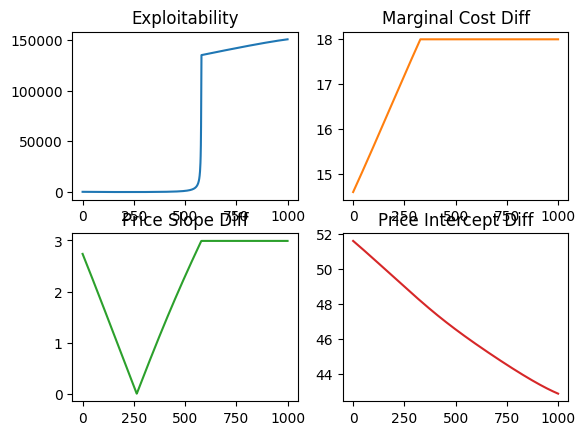

In [ ]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["price_slope"])
    intercept_hist.append(dist_dict["price_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Price Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Price Intercept Diff')




## Cournot Competition(Learn Marginal Cost)

In [ ]:
from statsmodels.graphics.gofplots import qqline
@jax.jit
def get_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    # deviation from q1_star
    reg1 = (price_func(q1+q2_star)-c)*q1 - (price_func(q1_star+q2_star)-c)*q1_star
    # deviation from q2_star
    reg2 = (price_func(q1_star+q2)-c)*q2 - (price_func(q1_star+q2_star)-c)*q2_star

    return reg1+reg2
@jax.jit
def get_neg_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star):
    cumul_regret = get_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star)
    return -1.0 * cumul_regret

def get_Bertrand_best_response(market, slope, intercept, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]

    q1 = (intercept-c)/(-2*slope) - q2_star/2
    q2 = (intercept-c)/(-2*slope) - q1_star/2


    return (q1, q2)


def get_Cournot_exploit(q1, q2, market, slope, intercept):
    c = market["marginal_cost"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    q1_opt = (intercept-c)/(-2*slope) - q2/2
    exploit1 = (price_func(q1_opt+q2)-c)*q1_opt - (price_func(q1+q2)-c)*q1

    q2_opt = (intercept-c)/(-2*slope) - q1/2
    exploit2 = (price_func(q1+q2_opt)-c)*q2_opt - (price_func(q1+q2)-c)*q2

    return exploit1+exploit2

### Experiment(GDA)

In [ ]:
def estimate_Cournot_params(q1_star, q2_star, goal_params, learn_rates, num_iters, slope, intercept, opt_name = "adam"):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)}

    init_q1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_q2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_q1, init_q2))


    def cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_cumul_regret(*f_action, l_action, slope, intercept, (q1_star, q2_star))

    def neg_cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_neg_Cournot_cumul_regret(*f_action, l_action, slope, intercept, (q1_star, q2_star))

    def exploit(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_exploit(*f_action, l_action, slope, intercept)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])


        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = ((100-20)/(-3*-3), (100-20)/(-3*-3))


# Equilibrium
p1_star = (100-20)/(-3*-3)
p2_star = (100-20)/(-3*-3)

slope = -3
intercept = 100


learn_rate_players = (2e-3, 3e-4)
num_iters = 50000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Cournot_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, opt_name)


Streaming output truncated to the last 5000 lines.
							Distance to true marginal_cost: 0.016735076904296875
							----------------------------------
		**************************** Player Iteration: 41680  ****************************
Leader Predicted: {'marginal_cost': Array(20.008, dtype=float32)}
Follower Predicted: (Array(8.895, dtype=float32), Array(8.895, dtype=float32))
							Exploitability: 0.0006
							Distance to true marginal_cost: 0.008251190185546875
							----------------------------------
		**************************** Player Iteration: 41690  ****************************
Leader Predicted: {'marginal_cost': Array(20.031, dtype=float32)}
Follower Predicted: (Array(8.892, dtype=float32), Array(8.892, dtype=float32))
							Exploitability: 0.0006
							Distance to true marginal_cost: 0.03093719482421875
							----------------------------------
		**************************** Player Iteration: 41700  ****************************
Leader Predicted: {'marginal_cost': Arr

Text(0.5, 1.0, 'Marginal Cost Diff')

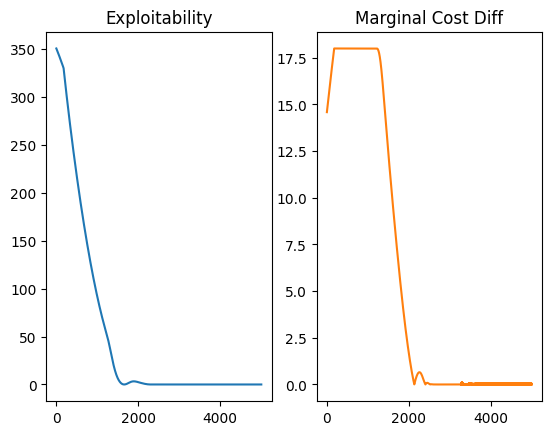

In [ ]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

# Static Fisher Market

## Solve Fisher

In [ ]:
import fisherMarketSolver as solver

In [ ]:
valuations = jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])
supplies = jnp.array([1.0, 1.0])
budgets = jnp.array([1/6, 1/3, 1/2])


# Create Market
market = solver.FisherMarket(valuations, budgets, supplies)

# Solve for market prices and allocations for desired utility function structure.

X, p = market.solveMarket("cobb-douglas", printResults=True)

Allocation: [[ 0.148  0.186]
 [ 0.459  0.203]
 [ 0.393  0.610]]
Prices: [ 0.508  0.492]


## Static Fisher Market (Learn Valuation only)

In [ ]:

###########################################################################################################################
# Fitting a Fisher market
@functools.partial(jax.jit, static_argnames=["util_type"])
def get_fisher_exploit(prices, allocations, market, budgets, util_type = "linear"):
    # budgets = jnp.clip(market["budgets"], a_min=1e-4)
    num_buyers, num_goods = allocations.shape
    valuations = jnp.clip(market["valuations"], a_min=1e-4)
    supplies = jnp.ones_like(prices)
    rho = jnp.ones(num_buyers) * 0.5
    # supplies = jnp.clip(market["supplies"], a_min=1e-4)
    # rho = market["rho"]

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return dual - primal


def get_fisher_best_response(market, budgets, f_star, util_type = "linear"):
    p_star, X_star = f_star
    num_buyers, num_goods = X_star.shape
    valuations = jnp.clip(market["valuations"], a_min=1e-4)
    supplies = jnp.ones_like(p_star)
    rho = jnp.ones(num_buyers) * 0.5

    p_star, X_star = f_star
    prices = p_star
    allocations = X_star

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return (prices, demands)

### Experiment(Exploit GD)

In [ ]:
def estimate_fisher_params_exploitGD(p_star, X_star, goal_params, learn_rates, num_iters, budgets, util_type = "linear", opt_name = "adam"):

    num_buyers, num_goods = X_star.shape
    init_market_params = {"valuations": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0, maxval = 10)}

    init_X = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
    init_p = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods,), minval = 0.0, maxval = 10.0)
    init_params = (init_market_params, (init_p, init_X))

    def exploit(l_action):
        return get_fisher_exploit(p_star, X_star, l_action, budgets, util_type)

    def best_response(l_action):
        return get_fisher_best_response(l_action, budgets, (p_star, X_star), util_type)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1e-4, a_max = 3.0), l_action)
        l_action_proj["valuations"] =  jax.tree_util.tree_map(lambda val: val / jnp.sum(val, axis=1)[:, jnp.newaxis], l_action_proj["valuations"])
        # l_action_proj["supplies"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=1.0), l_action_proj["supplies"])

        return l_action_proj

    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-4), x[1].clip(1e-4))

    problem = (exploit, best_response, l_project, f_project)

    return run_exploit_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name)

In [ ]:
# Equilibrium
X_star=jnp.array([[ 0.148,  0.186],
 [ 0.459,  0.203],
 [ 0.393,  0.610]])
p_star= jnp.array([ 0.508,  0.492])
# Real parameters
l_goal = {"valuations": jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])}
# print(l_goal["valuations"] / jnp.sum(l_goal["valuations"], axis=1)[:, jnp.newaxis])
# print(jax.nn.softmax(l_goal["valuations"], axis=1))
f_goal = (p_star, X_star)

# Other params
# valuations = jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])
supplies = np.array([1.0, 1.0])
budgets = np.array([1/6, 1/3, 1/2])

learn_rate_players = (5e-4, 1e-2)
num_iters = 5000
utility_type = "linear"
opt_name = "adam"

learn_rates = learn_rate_players

(l_action), exploit_hist, dist_hist = estimate_fisher_params_exploitGD(p_star, X_star, (l_goal, f_goal), learn_rates, num_iters, budgets, utility_type, opt_name)

Streaming output truncated to the last 5000 lines.
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'valuations': Array([[ 0.505,  0.495],
       [ 0.586,  0.414],
       [ 0.388,  0.612]], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 0.000,  0.339],
       [ 0.656,  0.000],
       [ 0.000,  1.016]], dtype=float32))
							Exploitability: 0.1131
							Distance to true valuations: 0.4451647400856018
							----------------------------------
		**************************** Player Iteration: 20  ****************************
Leader Predicted: {'valuations': Array([[ 0.509,  0.491],
       [ 0.581,  0.419],
       [ 0.393,  0.607]], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 0.328,  0.000],
       [ 0.656,  0.000],
       [ 0.000,  1.016]], dtype=float32))
							Exploitability: 0.1077
							Distance to true valuations: 0.4657336473464966
							----------

Text(0.5, 1.0, 'Valuations Diff')

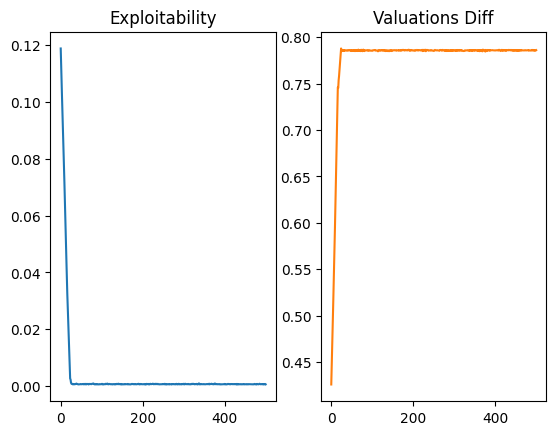

In [ ]:
val_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    val_hist.append(dist_dict["valuations"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(val_hist)), val_hist, 'tab:orange')
axs[1].set_title('Valuations Diff')

## Static Fisher Market (Learn Budgets only)

In [ ]:

###########################################################################################################################
# Fitting a Fisher market
@functools.partial(jax.jit, static_argnames=["util_type"])
def get_fisher_exploit(prices, allocations, market, valuations, util_type = "linear"):
    budgets = jnp.clip(market["budgets"], a_min=1e-4)
    # valuations = jnp.clip(market["valuations"], a_min=1e-4)
    rho = jnp.ones(allocations.shape[0])
    supplies = jnp.ones_like(prices)
    # rho = market["rho"]

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return dual - primal


def get_fisher_best_response(market, valuations, f_star, util_type = "linear"):
    p_star, X_star = f_star
    prices = p_star
    allocations = X_star

    budgets = jnp.clip(market["budgets"], a_min=1e-4)
    # valuations = jnp.clip(market["valuations"], a_min=1e-4)
    supplies = jnp.ones_like(prices)
    # rho = market["rho"]
    rho = jnp.ones(allocations.shape[0])

    p_star, X_star = f_star
    prices = p_star
    allocations = X_star

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return (prices, demands)

### Experiment(Exploit GD)

In [ ]:
def estimate_fisher_params_exploitGD(p_star, X_star, goal_params, learn_rates, num_iters, valuations, util_type = "linear", opt_name = "adam", epsilon=1e-1):

    num_buyers, num_goods = X_star.shape
    init_market_params = {"budgets": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers,), minval = 0.0, maxval = 10.0)}

    init_X = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
    init_p = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods,), minval = 0.0, maxval = 10.0)
    init_params = (init_market_params, (init_p, init_X))

    def exploit(l_action):
        return get_fisher_exploit(p_star, X_star, l_action, valuations, util_type)

    def best_response(l_action):
        return get_fisher_best_response(l_action, valuations, (p_star, X_star), util_type)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1e-4, a_max = 100.0), l_action)
        # l_action_proj["budgets"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1/3, a_max=1/3), l_action_proj["budgets"])
        # l_action_proj["supplies"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=1.0), l_action_proj["supplies"])

        return l_action_proj

    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-4), x[1].clip(1e-4))

    problem = (exploit, best_response, l_project, f_project)

    return run_exploit_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [ ]:
# Equilibrium
X_star=jnp.array([[ 0.148,  0.186],
 [ 0.459,  0.203],
 [ 0.393,  0.610]])
p_star= jnp.array([ 0.508,  0.492])

# Real parameters
l_goal = {"budgets": jnp.array([1/6, 1/3, 1/2])}
# print(l_goal["valuations"] / jnp.sum(l_goal["valuations"], axis=1)[:, jnp.newaxis])
# print(jax.nn.softmax(l_goal["valuations"], axis=1))
f_goal = (p_star, X_star)


# Other params
valuations = jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])
supplies = np.array([1.0, 1.0])
# budgets = np.array([1/6, 1/3, 1/2])


# print(get_fisher_best_response(l_goal, budgets, (p_star, X_star), "linear"))

learn_rate_players = (1e-2, 1e-2)
num_iters = 5000
opt_name = "adam"
utility_type = "linear"
learn_rates = learn_rate_players

(l_action), exploit_hist, dist_hist = estimate_fisher_params_exploitGD(p_star, X_star, (l_goal, f_goal), learn_rates, num_iters, valuations, utility_type, opt_name, epsilon=1e-6)

		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'budgets': Array([ 5.731,  0.992,  0.585], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 0.000,  11.649],
       [ 1.952,  0.000],
       [ 0.000,  1.188]], dtype=float32))
							Exploitability: 15.9752
							Distance to true budgets: 33.44743728637695
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'budgets': Array([ 0.151,  0.277,  0.429], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 0.000,  0.307],
       [ 0.546,  0.000],
       [ 0.000,  0.872]], dtype=float32))
							Exploitability: 0.1425
							Distance to true budgets: 0.2389051765203476
		**************************** Player Iteration: 2000  ****************************
Leader Predicted: {'budgets': Array([ 0.151,  0.277,  0.429], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], d

Text(0.5, 1.0, 'Budgets Diff')

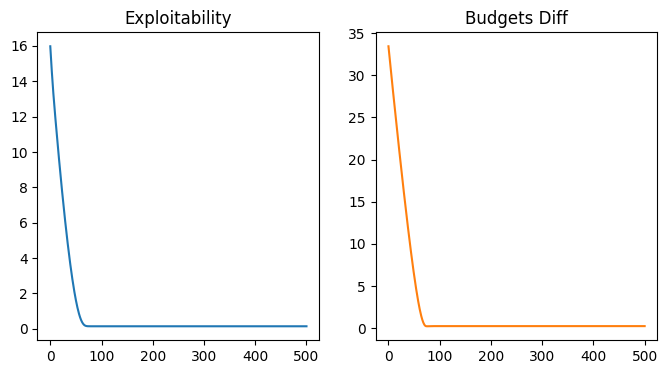

In [ ]:
budgets_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    budgets_hist.append(dist_dict["budgets"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(budgets_hist)), budgets_hist, 'tab:orange')
axs[1].set_title('Budgets Diff')

### Final Experiment

In [ ]:
def generate_fisher(num_markets, num_buyers, num_goods, utility_type):
    valuations_set = []
    budgets_set = []
    X_star_set = []
    p_star_set = []
    key = jax.random.PRNGKey(seed)
    for i in range(num_markets):
      key, subkey = jax.random.split(key)
      valuations = jax.random.uniform(key, shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
      valuations = valuations / jnp.sum(valuations, axis=1)[:, jnp.newaxis]
      budgets = jax.random.uniform(key, shape = (num_buyers,), minval = 0.0, maxval = 10.0)
      supplies = jnp.ones(num_goods)
      valuations_set.append(valuations)
      budgets_set.append(budgets)
      X_star, p_star = solver.FisherMarket(valuations, budgets, supplies).solveMarket(utility_type, printResults=False)
      X_star_set.append(X_star)
      p_star_set.append(p_star)

    return valuations_set, budgets_set, X_star_set, p_star_set


In [ ]:
def run_fisher_experiment(num_markets, num_buyers, num_goods, utility_type, learn_rates, num_iters, opt_name, epsilon = 1e-2):
    pass_count = 0
    final_exploits = []
    valuations_set, budgets_set, X_star_set, p_star_set = generate_fisher(num_markets, num_buyers, num_goods, utility_type)
    for i in range(num_markets):
        print(f"######################################################### Market {i} #########################################################")
        l_goal = {"budgets": budgets_set[i]}
        f_goal = (p_star_set[i], X_star_set[i])
        (l_action), exploit_hist, dist_hist = estimate_fisher_params_exploitGD(p_star_set[i], X_star_set[i], (l_goal, f_goal), learn_rates, num_iters, valuations_set[i], utility_type, opt_name, epsilon)
        final_exploits.append(exploit_hist[-1])
        if dist_hist[-1]["budgets"] < epsilon:
            pass_count += 1
    print(f"% of parameters recovered: {pass_count/num_markets}")
    print(f"Average exploitability: {np.mean(np.array(final_exploits))}")

    return pass_count/num_markets

percentage_recovered = run_fisher_experiment(10, 3, 2, "linear", (1e-2, 1e-2), 5000, "adam", epsilon = 1e-2)

######################################################### Market 0 #########################################################
		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'budgets': Array([ 5.751,  1.012,  0.605], dtype=float32)}
Follower Predicted: (Array([ 14.050,  10.769], dtype=float32), Array([[ 0.409,  0.000],
       [ 0.041,  0.041],
       [ 0.000,  0.056]], dtype=float32))
							Exploitability: 12.2555
							Distance to true budgets: 1.3006389141082764
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'budgets': Array([ 7.367,  6.702,  6.538], dtype=float32)}
Follower Predicted: (Array([ 14.050,  10.769], dtype=float32), Array([[ 0.524,  0.000],
       [ 0.270,  0.270],
       [ 0.000,  0.607]], dtype=float32))
							Exploitability: 0.5792
							Distance to true budgets: 0.3442608416080475
		**************************** Player Iteration: 2000  ************************

## Static Fisher Market (Learn Valuations + Budgets)

In [ ]:

###########################################################################################################################
# Fitting a Fisher market
@functools.partial(jax.jit, static_argnames=["util_type"])
def get_fisher_exploit(prices, allocations, market, util_type = "linear"):
    budgets = jnp.clip(market["budgets"], a_min=1e-4)
    valuations = jnp.clip(market["valuations"], a_min=1e-4)

    rho = jnp.ones(allocations.shape[0])
    supplies = jnp.ones_like(prices)


    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return dual - primal


def get_fisher_best_response(market, f_star, util_type = "linear"):
    p_star, X_star = f_star
    prices = p_star
    allocations = X_star

    budgets = jnp.clip(market["budgets"], a_min=1e-4)
    valuations = jnp.clip(market["valuations"], a_min=1e-4)
    supplies = jnp.ones_like(prices)
    rho = jnp.ones(allocations.shape[0])

    p_star, X_star = f_star
    prices = p_star
    allocations = X_star

    allocations = jnp.clip(allocations, a_min=1e-4)
    prices = jnp.clip(prices, a_min=1e-4)

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
            cost = max_bang_buck_goods.T @ prices
            cost = cost.clip(1e-4)

            return max_bang_buck_goods*(budget/cost)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            return (budget/(prices.T @ valuations)) * valuations

    elif util_type == "cobb-douglas":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_marshallian_demand(prices, budget, valuations, rho):
            _ = rho
            normalized_vals = valuations / jnp.sum(valuations)
            return normalized_vals*budget/prices

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_marshallian_demand(prices, budget, valuations, rho):
            v = jnp.power(valuations, 1/(1-rho))
            p_num = jnp.power(prices, 1/(rho-1))
            p_denom = jnp.power(prices, rho/(rho-1))
            return budget * ((v*p_num)/ (v.T @ p_denom))

    demands = jax.vmap(get_marshallian_demand, in_axes= [None, 0, 0, 0])(jax.lax.stop_gradient(prices), jax.lax.stop_gradient(budgets), jax.lax.stop_gradient(valuations), jax.lax.stop_gradient(rho))
    utils_br = get_utils(demands)
    excess_supply = supplies - jnp.sum(allocations, axis = 0)


    primal = budgets.T @ jnp.log(get_utils(allocations).clip(1e-5)) + jnp.sum(jax.lax.stop_gradient(budgets))*jnp.min(excess_supply)

    dual = prices.T @ (supplies.T - jnp.sum(demands, axis = 0)) + budgets.T @ jnp.log(utils_br.clip(1e-5))

    # print("sum of budgets", jnp.sum(budgets))
    # print("sum of prices", jnp.sum(prices))
    return (prices, demands)

### Experiment(Exploit GD)

In [ ]:
def estimate_fisher_params_exploitGD(p_star, X_star, goal_params, learn_rates, num_iters, util_type = "linear", opt_name = "adam", epsilon = 1e-2):

    num_buyers, num_goods = X_star.shape
    init_market_params = {"budgets": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers,), minval = 0.0, maxval = 10.0),
                          "valuations": jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0, maxval = 10)}

    init_X = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
    init_p = jax.random.uniform(jax.random.PRNGKey(seed), shape = (num_goods,), minval = 0.0, maxval = 10.0)
    init_params = (init_market_params, (init_p, init_X))

    def exploit(l_action):
        return get_fisher_exploit(p_star, X_star, l_action, util_type)

    def best_response(l_action):
        return get_fisher_best_response(l_action, (p_star, X_star), util_type)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1e-4, a_max = 100.0), l_action)
        l_action_proj["valuations"] =  jax.tree_util.tree_map(lambda val: val / jnp.sum(val, axis=1)[:, jnp.newaxis], l_action_proj["valuations"])
        # l_action_proj["supplies"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=1.0), l_action_proj["supplies"])

        return l_action_proj

    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-4), x[1].clip(1e-4))

    problem = (exploit, best_response, l_project, f_project)

    return run_exploit_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [ ]:
# Equilibrium
X_star=jnp.array([[ 0.148,  0.186],
 [ 0.459,  0.203],
 [ 0.393,  0.610]])
p_star= jnp.array([ 0.508,  0.492])

# Real parameters
l_goal = {"budgets": jnp.array([1/6, 1/3, 1/2]),
          "valuations": jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])}
# print(l_goal["valuations"] / jnp.sum(l_goal["valuations"], axis=1)[:, jnp.newaxis])
# print(jax.nn.softmax(l_goal["valuations"], axis=1))
f_goal = (p_star, X_star)

# Other params
valuations = jnp.array([[0.45, 0.55], [0.7, 0.3], [0.4, 0.6]])
supplies = jnp.array([1.0, 1.0])
# budgets = jnp.array([1/6, 1/3, 1/2])

learn_rate_players = (5e-3, 1e-2)
num_iters = 5000
opt_name = "adam"
utility_type = "linear"

learn_rates = learn_rate_players

(l_action), exploit_hist, dist_hist = estimate_fisher_params_exploitGD(p_star, X_star, (l_goal, f_goal), learn_rates, num_iters, utility_type, opt_name)

		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'budgets': Array([ 5.736,  0.997,  0.590], dtype=float32), 'valuations': Array([[ 0.457,  0.543],
       [ 0.807,  0.193],
       [ 0.254,  0.746]], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 0.000,  11.659],
       [ 1.962,  0.000],
       [ 0.000,  1.198]], dtype=float32))
							Exploitability: 16.1059
							Distance to true budgets: 33.47832107543945
							Distance to true valuations: 0.5857630372047424
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'budgets': Array([ 1.234,  0.333,  0.499], dtype=float32), 'valuations': Array([[ 0.508,  0.492],
       [ 0.511,  0.489],
       [ 0.508,  0.492]], dtype=float32)}
Follower Predicted: (Array([ 0.508,  0.492], dtype=float32), Array([[ 2.429,  0.000],
       [ 0.655,  0.000],
       [ 0.000,  1.015]], dtype=float32))
							Exploitability: 

Text(0.5, 1.0, 'Valuations Diff')

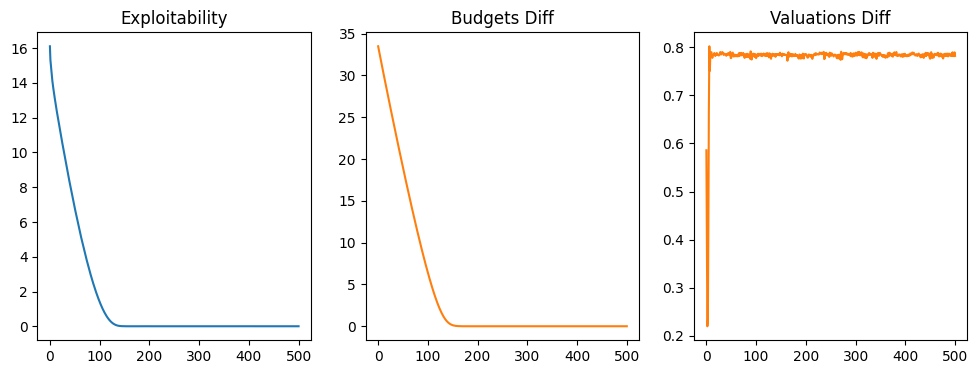

In [ ]:
budgets_hist = []
valuations_hist = []
for dist_dict in dist_hist:
    budgets_hist.append(dist_dict["budgets"])
    valuations_hist.append(dist_dict["valuations"])


fig, axs = plt.subplots(1, 3,figsize = (12,4))
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(budgets_hist)), budgets_hist, 'tab:orange')
axs[1].set_title('Budgets Diff')

axs[2].plot(range(len(valuations_hist)), valuations_hist, 'tab:orange')
axs[2].set_title('Valuations Diff')

### Final Experiments

In [ ]:
def generate_fisher(num_markets, num_buyers, num_goods, utility_type):
    valuations_set = []
    budgets_set = []
    X_star_set = []
    p_star_set = []
    key = jax.random.PRNGKey(seed)
    for i in range(num_markets):
      key, subkey = jax.random.split(key)
      valuations = jax.random.uniform(key, shape = (num_buyers, num_goods), minval = 0.0, maxval = 10.0)
      valuations = valuations / jnp.sum(valuations, axis=1)[:, jnp.newaxis]
      budgets = jax.random.uniform(key, shape = (num_buyers,), minval = 0.0, maxval = 10.0)
      supplies = jnp.ones(num_goods)
      valuations_set.append(valuations)
      budgets_set.append(budgets)
      X_star, p_star = solver.FisherMarket(valuations, budgets, supplies).solveMarket(utility_type, printResults=False)
      X_star_set.append(X_star)
      p_star_set.append(p_star)

    return valuations_set, budgets_set, X_star_set, p_star_set



In [ ]:
def run_fisher_experiment(num_markets, num_buyers, num_goods, utility_type, learn_rates, num_iters, opt_name, epsilon = 1e-2):
    pass_count = 0
    final_exploits = []
    valuations_set, budgets_set, X_star_set, p_star_set = generate_fisher(num_markets, num_buyers, num_goods, utility_type)
    for i in range(num_markets):
        print(f"######################################################### Market {i} #########################################################")
        l_goal = {"budgets": budgets_set[i],
                  "valuations": valuations_set[i]}
        f_goal = (p_star_set[i], X_star_set[i])
        (l_action), exploit_hist, dist_hist = estimate_fisher_params_exploitGD(p_star_set[i], X_star_set[i], (l_goal, f_goal), learn_rates, num_iters, utility_type, opt_name, epsilon)
        final_exploits.append(exploit_hist[-1])
        if dist_hist[-1]["budgets"] + dist_hist[-1]["valuations"] < epsilon:
            pass_count += 1
    print(f"% of parameters recovered: {pass_count/num_markets}")
    print(f"Average exploitability: {np.mean(np.array(final_exploits))}")

    return pass_count/num_markets
percentage_recovered = run_fisher_experiment(10, 3, 2, "linear", (1e-2, 1e-2), 5000, "adam", epsilon = 1e-2)
print(percentage_recovered)



######################################################### Market 0 #########################################################
		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'budgets': Array([ 5.731,  1.012,  0.605], dtype=float32), 'valuations': Array([[ 0.457,  0.543],
       [ 0.806,  0.194],
       [ 0.255,  0.745]], dtype=float32)}
Follower Predicted: (Array([ 14.050,  10.769], dtype=float32), Array([[ 0.000,  0.532],
       [ 0.072,  0.000],
       [ 0.000,  0.056]], dtype=float32))
							Exploitability: 14.9176
							Distance to true budgets: 1.301099419593811
							Distance to true valuations: 3.649888277053833
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'budgets': Array([ 7.368,  6.716,  6.538], dtype=float32), 'valuations': Array([[ 0.661,  0.339],
       [ 0.572,  0.428],
       [ 0.356,  0.644]], dtype=float32)}
Follower Predicted: (Array([ 14.050,  10.769], dtyp